In [2]:
import random

import os.path as osp

import networkx as nx
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.nn import GINConv, global_add_pool, MessagePassing, GraphConv, GCNConv

from matplotlib import pyplot as plt
from captum.attr import Saliency, IntegratedGradients
from tqdm.notebook import tqdm as tq
from collections import defaultdict

# Creating a dataset
We create a $G_{n,p}$ random graph with $n=20$ and $p=0.2$. Initially the color for all nodes are blue (constant feature=1). We randomly select 3 nodes and assign them the color yellow(feature=0) such that there is at most on edge between two yellow nodes, therefore the explanation is unique. The task is to classify whether a graph has an edge between two yellow nodes or not.

In [3]:
def create_graph():
    g=nx.erdos_renyi_graph(20,0.2)
    while True:
        colored_nodes = random.sample(list(g.nodes()),3)
        label = 0
        colored_edges = 0
        for u in colored_nodes:
            for v in colored_nodes:
                if u!=v and g.has_edge(u,v):
                    label = 1
                    colored_edges +=1
        if colored_edges <= 2: # at most 1 edge between colored nodes
            break
    data = from_networkx(g)
    data.y = torch.tensor([label])
    
    data.x = torch.ones((g.number_of_nodes(),1))
    
    for u in colored_nodes:
        data.x[u,0]=0

    return data

## We create 1000 graphs for train/test

In [4]:
GRAPH_NUM = 1000
dataset = [create_graph() for i in range(GRAPH_NUM)]
NUM_FEATURES = 1

# GNN Model
We use a general GNN model where can configure via initialization parameters

In [5]:
class Net(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers, concat_features, pre_processing):
        super(Net, self).__init__()
        dim = 32
        self.convs = torch.nn.ModuleList()
        self.pre_processing = pre_processing

        if self.pre_processing:
            self.pre_fc1 = Linear(num_node_features, dim)
            self.pre_fc2 = Linear(dim, dim)
            before_conv_dim = dim
        else:
            before_conv_dim = num_node_features
        self.convs.append(GraphConv(before_conv_dim, dim))
        for i in range(num_layers - 1):
            self.convs.append(GraphConv(dim, dim))
        self.concat_features = concat_features
        if concat_features:
            self.fc1 = Linear(dim * num_layers + before_conv_dim, dim)
        else:
            self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        if self.pre_processing:
            x = F.relu(self.pre_fc1(x))
            x = F.relu(self.pre_fc2(x))
        xs = [x]
        for conv in self.convs:
            x = conv(x, edge_index, edge_weight)
            x = F.relu(x)
            xs.append(x)
        if self.concat_features:
            x = torch.cat(xs, dim=1)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


In [7]:
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=64)
train_loader = DataLoader(train_dataset, batch_size=64)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, optimizer):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(model, loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

def train_and_test(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=5e-4)
    pbar = tq(range(150))
    for epoch in pbar:
        train_loss = train(model, optimizer)
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)
        pbar.set_postfix(train_loss = train_loss,train_acc=train_acc,test_acc=test_acc)
#         print('Epoch: {:03d}, Train Loss: {:.7f}, '
#               'Train Acc: {:.7f}, Test Acc: {:.7f}'.format(epoch, train_loss,
#                                                            train_acc, test_acc))

In [9]:
model1 = Net(num_node_features=1, num_classes=2,num_layers=3, concat_features=True, pre_processing=False).to(device)
model1.desc='without_preprocess'

model2 = Net(num_node_features=1, num_classes=2,num_layers=3, concat_features=True, pre_processing=True).to(device)
model2.desc='with_preprocess'

In [10]:
train_and_test(model1)
train_and_test(model2)

# Defining the explanation method
Here we use saliency and integrated gradients on edge weights, we use the same method throughout the whole experiment in order to show how much model architecture can affect the explanation

In [20]:
def explain(model, method, data, target):
    def model_forward(edge_mask, data):
        batch = torch.zeros(data.x.shape[0], dtype=int)
        out = model(data.x, data.edge_index, batch, edge_mask)
        return out
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'gradients':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,), abs=False)
    else:
        raise Exception('Unknown explanation method')

    edge_mask = mask.detach().numpy()
    
    # we use the absolute value since it does not matter
    # that edge weight affect the result positvely or negatively
    edge_mask = np.abs(edge_mask)
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    
    edge_attribution = defaultdict(float)
    for value, u, v in list(zip(edge_mask, *data.edge_index.numpy())):            
        edge_attribution[(min(u,v),max(u,v))] += value
    return edge_attribution

In [12]:
def make_colorblind_friendly(node_color):
    colors = []
    for value in node_color:
        colors.append('#FFB000' if value == 0 else '#648FFF') # Based on IBM palette
    return colors

# Visualizing the explanations
Here we pick a single graph from the dataset, and try to explain the prediction for both models via the same explanation method (Integrated Gradients or Edge Gradients)

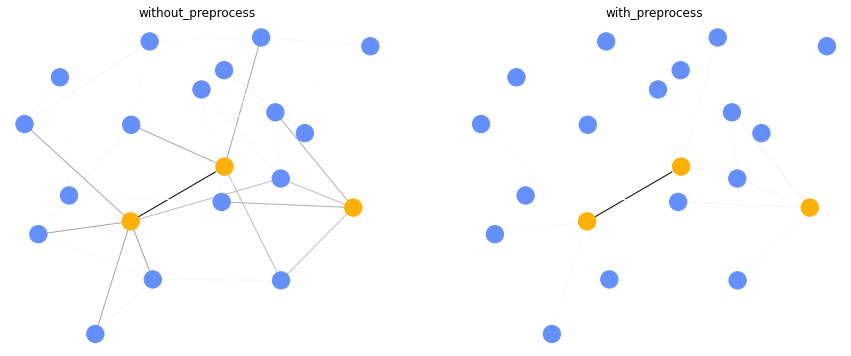

In [21]:
dds = random.choice([data for data in dataset if data.y.item()])
METHOD = 'ig' # you can change this to gradients
plt.figure(figsize=(15,6))
g = to_networkx(dds).to_undirected()
pos = nx.kamada_kawai_layout(g)
for idx, model in enumerate([model1,model2]):
    model.eval()
    edge_attribution = explain(model, METHOD, dds,target=dds.y.item())

    plt.subplot(1,2,idx+1)
    plt.title(model.desc)
    node_color = -dds.x.numpy()
    edge_color = [edge_attribution[(u,v)] for u,v in g.edges()]
    nx.draw(g, pos=pos, node_color=make_colorblind_friendly(node_color), edge_color=edge_color, edge_cmap=plt.get_cmap('Greys'))

plt.show()

## Save plots as pdf

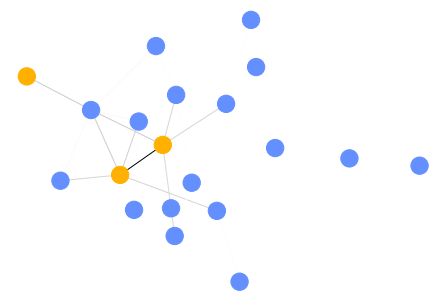

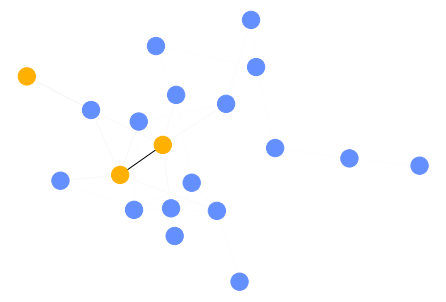

In [30]:
for idx, model in enumerate([model1,model2]):
#     pp = PdfPages(model.desc+'.pdf')
    f = plt.figure()
    plt.clf()
    model.eval()
    edge_attribution = explain(model, METHOD, dds,target=dds.y.item())
    node_color = -dds.x.numpy()
    edge_color = [edge_attribution[(u,v)] for u,v in g.edges()]
    nx.draw(g, pos=pos, node_color=make_colorblind_friendly(node_color), edge_color=edge_color, edge_cmap=plt.get_cmap('Greys'))
    plt.show()
    f.savefig(model.desc+".pdf")
#     pp.savefig()


# Quantifiying the differences
We calculate the attribution value for all unimportant edges and we expect them to be close to 0, we plot the distribution of attribution value for unimportant edges on all graphs for both models. We also consider an explanation correct, if the most important edge in explanation is the edge between two yellow nodes and use that to calculate the explanation accuracy.

In [22]:
def calculate_avg_wrong(model):
    METHOD = 'ig'
    model.eval()
    avg_wrong_masks = []
    accuracy = []

    for dds in tq(dataset):
        if not dds.y.item():
            continue
        mask_sum = []
        edge_attribution = explain(model, METHOD, dds,target=dds.y.item())
        for (u, v), value in edge_attribution.items():
            if dds.x[u].item() != 1.0 and dds.x[v].item() != 1.0: # skip the important edge
                right_edge_value = value
                continue
            mask_sum.append(value)
        if max(edge_attribution.values()) == right_edge_value:
            accuracy.append(1)
        else:
            accuracy.append(0)
        avg_wrong_masks.append(np.mean(mask_sum))
    return avg_wrong_masks, accuracy

In [23]:
avg_wrong_masks_model1, accuracy_model1 = calculate_avg_wrong(model1)
avg_wrong_masks_model2, accuracy_model2 = calculate_avg_wrong(model2)

In [28]:
print('Explanation accuracy for model ' + model1.desc, np.mean(accuracy_model1))
print('Explanation accuracy for model ' + model2.desc, np.mean(accuracy_model2))

Explanation accuracy for model without_preprocess 1.0
Explanation accuracy for model with_preprocess 1.0


Altough the explanation method can detect the most important edge correctly in both models, it generally assigns higher value to unimportant edges when the model does not preprocess the node features.

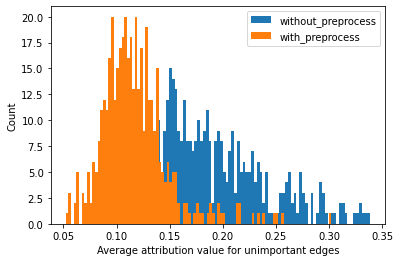

In [27]:
plt.hist(avg_wrong_masks_model1, bins=100, label=model1.desc)
plt.hist(avg_wrong_masks_model2, bins=100, label=model2.desc)
plt.ylabel('Count')
plt.xlabel('Average attribution value for unimportant edges')
plt.legend()